In [33]:
from ortools.sat.python import cp_model
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import pandas as pd
import time
import csv

In [34]:
def generateGanttChart(R,P,T,robotSchedule,startTimeSchedule,processTime):
    tasks_per_product = 3
    products = ['Product ' + str(i) for i in range(1, P+1)]
    robots = ['Robot ' + str(i) for i in range(1, R+1)]
    df = pd.DataFrame(columns=['Task', 'Robot', 'Product', 'Start', 'Finish'])
    task_id = 0
    colors = {'Product 1': 'red', 'Product 2': 'green', 'Product 3': 'blue', 'Product 4': 'orange', 'Product 5': 'purple','Product 6': 'black','Product 7': 'pink','Product 8': 'gray','Product 9': 'yellow','Product 10': 'brown',}
    estimatedTime = sum(processTime,[])
    for product in products:
        for task_num in range(1, tasks_per_product+1):
            task_name = product + ' Task ' + str(task_num)
            robot = robotSchedule[task_id]+1
            start = startTimeSchedule[task_id]
            finish = startTimeSchedule[task_id]+estimatedTime[task_id]
            df.loc[task_id] = [task_name, robot, product, start, finish]
            task_id += 1
            
    df['task_duration'] = df['Finish'] - df['Start']
    print(df)
    # Create the Gantt chart
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, row in df.iterrows():
        ax.barh(y=row['Robot'], width=row['task_duration'], left=row['Start'], height=0.5, color=colors[row['Product']])
        ax.text(row['Start'], row['Robot'], row['Task'], ha='left', va='center', color='white', fontsize=8)
    
    # Set the x-axis and y-axis labels
    ax.set_title('Work Schedule')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Robot')
    # Set the y-axis ticks
    ax.set_yticks(range(1, R+1))
    ax.set_yticklabels(robots)
    # Set the x-axis range to start at 0
    ax.set_xlim([0, df['Finish'].max()])
    
    # Show the Gantt chart
    plt.show()

In [35]:
def writeDataToCSV(id,productRobot,productStartTime):
    header = ['id','goal_positions', 'target_time']
    data = []
    for i in range(len(productRobot)):
        data.append([id,productRobot[i],productStartTime[i]])

    with open('./data/UPsolution.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        # write the header
        writer.writerow(header)
        # write the data
        writer.writerows(data)

In [36]:
# Declare the model
model = cp_model.CpModel()

In [37]:
# Define Constant Variables

# Assume that there are 4 robots and 5 products need to be processed.
# Each product process contains 3 tasks.
R=6
P=6
T=3
M = 100000
# Estimated Processing Time
E = [50,28,48]
changeTime = 40
# Transportation Time
L = [[0 for j in range(R)] for i in range(R) ]

# Color
color = [[1,1,2],[2,3,1],[3,2,2],[1,3,2],[3,1,3],
         [3,1,2]]

Row = 30
Column = 4
#Robots = [0,28,52,80,116,3,31,55,83,119]
Robots = [0,28,52,3,31,55]
#Map = np.arange(120).reshape(Row, Column)
for k in range(R):
    for w in range(R):
        if k==w:
            L[k][w]=0
        elif k==w-3 or k-3==w:
            L[k][w]=4
        elif k<=2 and w <=2:
            L[k][w]=int(np.abs((Robots[k]-Robots[w])/4)+1)
        elif k<=2 and w>2:
            L[k][w]=int(np.abs((Robots[w-3]-Robots[k])/4)+1+4)
        elif k>2 and w<=2:
            L[k][w]=int(np.abs((Robots[k-3]-Robots[w])/4)+1+4)
        elif k>2 and w>2:
            L[k][w]=int(np.abs((Robots[k]-Robots[w])/4)+1)

In [39]:
# Define Decision Variables

# Start time of task ij
s = [[model.NewIntVar(0, M, f's_{i}_{j}') for j in range(T)] for i in range(P)]

# Task allocation. Equals 1 if t_{ij} is performed on robot k, 0 otherwise.
x = [[[model.NewBoolVar(f'x_{i}_{j}_{k}') for k in range(R)] for j in range(T)] for i in range(P)]

# Task sequence. Equals 1 if x_{ij} is performed before x_{gh} on robot k, 0 otherwise.
y = [[[[[model.NewBoolVar(f'y_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]

print('Number of variables =', model.NumVariables())

In [40]:
# Add intermediate variables

# Two variables multiplication. xp = x[i][j][k]*x[g][h][k]
xp = [[[[[model.NewIntVar(0,1,f'xp_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):
                        model.Add(xp[i][j][g][h][k]<=x[i][j][k])
                        model.Add(xp[i][j][g][h][k]<=x[g][h][k])
                        model.Add(xp[i][j][g][h][k]>=x[i][j][k]+x[g][h][k]-1)


# Workload
v = [model.NewIntVar(0,M,f'v_{k}') for k in range(R)]
c = [[[x[i][j][k]*E[j] for k in range(R)] for j in range(T)] for i in range(P)]
workLoad = [sum(sum([[c[i][j][k] for j in range(T)] for i in range(P)],[])) for k in range(R)]

#workLoad_hat = model.NewIntVar(0,M,'wh')
workLoad_hat = sum(workLoad) 

'\nfor k in range(R):\n    model.Add(v[k]>=workLoad[k]-workLoad_hat)\n    model.Add(v[k]>=workLoad_hat-workLoad[k])\n'

In [41]:
# Robots of next task
f = [[[[model.NewIntVar(0,1,f'f_{i}_{j}_{k}_{w}') for w in range(R)] for k in range(R)] for j in range(T-1)] for i in range(P)]
for i in range(P):
    for j in range(T-1):
        for k in range(R):
            for w in range(R):
                model.Add(f[i][j][k][w]<=x[i][j][k])
                model.Add(f[i][j][k][w]<=x[i][j+1][w])
                model.Add(f[i][j][k][w]>=x[i][j][k]+x[i][j+1][w]-1)
                
# Equals 1 when previous task has different predefined color
penalty = [[[[model.NewIntVar(0,1,f'penalty_{i}_{j}_{g}_{h}')  for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for i in range(P):
    for j in range(T):
        for g in range(P):
            for h in range(T):
                penalty[i][j][g][h] = ((color[i][j] - color[g][h])!=0)


# Equals 1 when task ij is next to and before task gh
z = [[[[[model.NewBoolVar(f'z_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]

# Sum of how many tasks are performed before task gh
#pTasks = [[[solver.IntVar(0,solver.infinity(),f'pTasks_{i}_{j}_{k}') for k in range(R)] for j in range(T)] for i in range(P)]
pTasks = [[[0 for k in range(R)] for h in range(T)] for g in range(P)]
for k in range(R):
    for g in range(P):
        for h in range(T):
            #model.Add(sum(z[i][j][g][h][k] for i in range(P) for j in range(T)) == x[g][h][k])
            pTasks[g][h][k] = sum(y[i][j][g][h][k] for j in range(T) for i in range(P))

difference = [[[[[model.NewIntVar(0,M,f'difference_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
zeroFlag = [[[[[model.NewBoolVar(f'zeroFlag{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
maxVaule = [[[[[model.NewIntVar(0,M,f'maxVaule_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
temporaryVariable = [[[[[model.NewIntVar(-10,10,f'zhongjian_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]

for k in range(R):
    for g in range(P):
        for h in range(T):
            for i in range(P):
                for j in range(T):
                    if i==g and j==h:
                        model.Add(difference[i][j][g][h][k] == 10)
                        model.Add(z[i][j][g][h][k] == 1)
                        
                    else:
                        model.AddMaxEquality(maxVaule[i][j][g][h][k], [(pTasks[g][h][k] - pTasks[i][j][k]),-(pTasks[g][h][k] - pTasks[i][j][k])])
                        model.Add(difference[i][j][g][h][k] >= (pTasks[g][h][k] - pTasks[i][j][k]))
                        model.Add(difference[i][j][g][h][k] >= -(pTasks[g][h][k] - pTasks[i][j][k]))
                        model.Add(difference[i][j][g][h][k] <= maxVaule[i][j][g][h][k])
                        model.AddMinEquality(zeroFlag[i][j][g][h][k], [difference[i][j][g][h][k],1])
                        model.AddMinEquality(temporaryVariable[i][j][g][h][k], [difference[i][j][g][h][k]-1,1])
                        model.Add(z[i][j][g][h][k]==temporaryVariable[i][j][g][h][k]).OnlyEnforceIf(zeroFlag[i][j][g][h][k])
                        model.Add(z[i][j][g][h][k] == 1).OnlyEnforceIf(zeroFlag[i][j][g][h][k].Not())
                    
           
# colorChange = z*penalty
# Equals 1 when previous task performed on the same robot has different predefined color
colorChange = [[[[[model.NewIntVar(0,1,f'colorChange_{i}_{j}_{g}_{h}_{k}') for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):
                        model.Add(colorChange[i][j][g][h][k] <= penalty[i][j][g][h])
                        model.Add(colorChange[i][j][g][h][k] <= z[i][j][g][h][k].Not())
                        model.Add(colorChange[i][j][g][h][k] >= penalty[i][j][g][h]+z[i][j][g][h][k].Not()-1)
                    else:
                        model.Add(colorChange[i][j][g][h][k] == 0)
                        
# Penalty time
pt = [[[[[colorChange[i][j][g][h][k]*changeTime for k in range(R)] for h in range(T)] for g in range(P)] for j in range(T)] for i in range(P)]

In [42]:
# Define Objective functions

# Minimize the makespan
makespan = model.NewIntVar(0, M, f'm')
for i in range(P):
    for j in range(T):
        model.Add(makespan>=s[i][j]+E[2])
#solver.Minimize(cycleTime)
z1 = makespan

# Minimize the variance of workload
#solver.Minimize(1/R*sum(y))
#z2 = model.NewIntVar(0,M,'z2')
z2 = sum(v)
#model.AddDivisionEquality(z2,sum(v),R)

# Weights of each objective functions
weights = [(1, 0), (0.9, 0.1), (0.8, 0.2), (0.7, 0.3), (0.6, 0.4), (0.5, 0.5), (0.4, 0.6), (0.3, 0.7), (0.2, 0.8), (0.1, 0.9)]

In [43]:
# Define constraints

# Constraints of convert workload function
for k in range(R):
    model.Add(v[k]>=workLoad[k]*R-workLoad_hat)
    model.Add(v[k]>=workLoad_hat-workLoad[k]*R)

# One task could be only processed on one robot
for i in range(P):
    for j in range(T):
            model.Add(sum([x[i][j][k]*1 for k in range(R)])==1)

# Every Start time should bigger than zero
for i in range(P):
    for j in range(T):
        model.Add(s[i][j]>=0)
    
# The order between two tasks of one product
routeLength = [[[[f[i][j][k][w]*L[k][w] for w in range(R)] for k in range(R)] for j in range(T-1)] for i in range(P)]
for k in range(R):
    for i in range(P):
        for j in range(T-1):
            model.Add(s[i][j+1]-(s[i][j]+E[j]+sum(sum(routeLength[i][j],[])))>=0)
            #+sum(sum(int(routeLength[i][j]),[]))
# Completion condition
for i in range(P):
    model.Add(sum(sum([[x[i][j][k]*1 for k in range(R)] for j in range(T)],[]))==3)
    
# Must at least one robot could run
for k in range(R):
    model.Add(20-sum(sum([[x[i][j][k]*1 for j in range(T)] for i in range(P)],[]))>=0)

# Squency of two tasks
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):    
                        model.Add(y[i][j][g][h][k]+y[g][h][i][j][k] == xp[i][j][g][h][k])
                    else:
                        model.Add(y[i][j][g][h][k]==0)

# One robot only can process one task at the same time
for k in range(R):
    for i in range(P):
        for j in range(T):
            for g in range(P):
                for h in range(T):
                    if not(i==g and j==h):
                        model.Add(s[g][h]-s[i][j]-E[j]-pt[i][j][g][h][k]>=0).OnlyEnforceIf(y[i][j][g][h][k])

In [44]:
start_time = time.time()
# Solve the problem.
#print(f'Solving with {model.SolverVersion()}')

objective = 14 * z1 + 1 * z2
model.Minimize(objective)
solver = cp_model.CpSolver()
solver.parameters.num_search_workers = 16
#solver.parameters.max_time_in_seconds = 600.0
status = solver.Solve(model)
end_time = time.time()
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
#if status == cp_model.OPTIMAL:
    print(f'Minimum of objective function: {solver.ObjectiveValue()}\n')
else:
    print('No solution found.')
running_time = end_time - start_time
print("The running time is:", running_time, "seconds.")
solver.parameters.log_search_progress = True
solver.log_callback = print  # (str)->None

KeyboardInterrupt: 

In [ ]:
productRobot = []
productStartTime = []
processTime = np.zeros((P,T), dtype=int)
for i in range(P):
    for j in range(T):
        productStartTime.append(solver.Value(s[i][j]))
        for k in range(R):
            if solver.Value(x[i][j][k]) == 1:
                productRobot.append(k)
            processTime[i][j] = E[j]

In [ ]:
writeDataToCSV(1,productRobot,productStartTime)

                Task  Robot    Product  Start  Finish  task_duration
0   Product 1 Task 1      5  Product 1      0      50             50
1   Product 1 Task 2      5  Product 1     54      82             28
2   Product 1 Task 3      4  Product 1    122     170             48
3   Product 2 Task 1      1  Product 2      0      50             50
4   Product 2 Task 2      4  Product 2     54      82             28
5   Product 2 Task 3      2  Product 2    122     170             48
6   Product 3 Task 1      4  Product 3      0      50             50
7   Product 3 Task 2      1  Product 3     54      82             28
8   Product 3 Task 3      6  Product 3    122     170             48
9   Product 4 Task 1      6  Product 4      0      50             50
10  Product 4 Task 2      3  Product 4     54      82             28
11  Product 4 Task 3      1  Product 4    122     170             48
12  Product 5 Task 1      3  Product 5      0      50             50
13  Product 5 Task 2      6  Produ

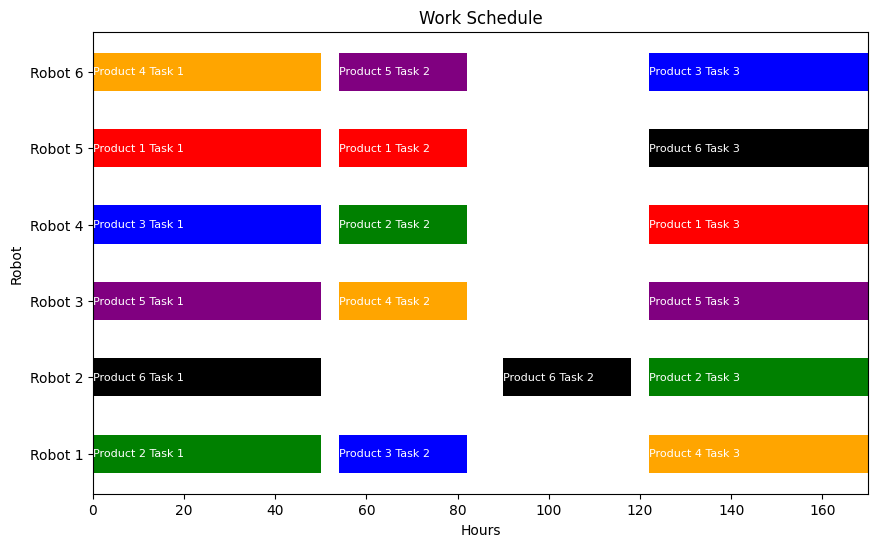

In [ ]:
generateGanttChart(R,P,T,productRobot,productStartTime,processTime.tolist())